In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#William Connor Parham
#Dr. Hairong Qi
#COSC 522
#Project 1
#9/19/2023

**Read In Training and Testing Set**


Text(0.5, 1.0, 'Positive and Negative Synthetic training Data')

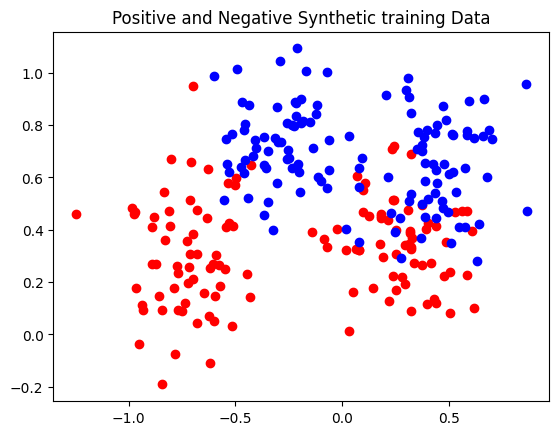

In [88]:
#Read in the training and testing set
# training_set = pd.read_csv('synth.tr', delim_whitespace=True)
# testing_set = pd.read_csv('synth.te', delim_whitespace=True)
# print(training_set)
# print(testing_set)

# df_pos = training_set.loc[training_set['yc'] == 1]
# df_neg = training_set.loc[training_set['yc'] == 0]
# df_pos_x = df_pos['xs']
# df_pos_y = df_pos['ys']

# df_neg_x = df_neg['xs']
# df_neg_y = df_neg['ys']

# plt.scatter(df_pos_x, df_pos_y,c='red')
# plt.scatter(df_neg_x, df_neg_y, c='blue')
# plt.title('Positive and Negative Synthetic training Data')
#############################################################


#Read in our training and testing files
training_set = np.loadtxt("synth.tr",skiprows=1)
testing_set = np.loadtxt("synth.te", skiprows=1)

#Instantiate arrays to graph our training data
training_set_x_c1, training_set_y_c1 = [], []
training_set_x_c2, training_set_y_c2 = [], []
testing_set_x_c1, testing_set_y_c1 = [], []
testing_set_x_c2, testing_set_y_c2 = [], []

#sort our training data by class.
for item in training_set:
    if(item[2] == 0):
        training_set_x_c1.append(item[0])
        training_set_y_c1.append(item[1])
    else:
        training_set_x_c2.append(item[0])
        training_set_y_c2.append(item[1])

#Plot our data
plt.scatter(training_set_x_c1, training_set_y_c1,c='red')
plt.scatter(training_set_x_c2, training_set_y_c2, c='blue')
plt.title('Positive and Negative Synthetic training Data')

**Maximum Posterier Probability Classifier**

In [89]:
class MED_Classifier():
    
    def _innit_(self):
        self.X_train = [] #x_train data
        self.y_train = [] #y_train data
        self.classes = [] #list of classes
        self.means = [] #list to hold class means used in predict.
        self.sigmas = None #list to hold each sigma value
        


    #We will fit our training_set to the classifier here.  This is what "trains" our model to be able to predict things.
    def fit(self,training_set):
        #The first thing we need to do is sepperate our training set into lists based on class.
        #We can do this by concatting every class in our training set then calling np.unique to get all unique values.
        self.classes = np.unique(training_set[:,2])
        class_means = [] #list to hold all class means
        class_0_data, class_1_data = [], [] #list to hold all points of class 0 and 1 data
        class_0_data_nc, class_1_data_nc = [], [] #list to hold all points of class 0 and 1 data without the class variable
        class_0_centered, class_1_centered = [], [] #list to hold centered data after subtracting mean
        c0_cov = [] #list to hold the covariance matrix for class 0
        c1_cov = [] #list to hold the covariance matrix for class 1
        sigmas = [] #list to gold the sigma values for each class

        for item in training_set:
            if(item[2] == 0):
                class_0_data.append(item)
            else:
                class_1_data.append(item)

        #Here I am stripping the class column off each array
        temp = []
        for subarray in class_0_data:
            temp.append(subarray[:2])
        class_0_data_nc = temp
        temp = []
        for subarray in class_1_data:
            temp.append(subarray[:2])
        class_1_data_nc = temp

        #Calculate the mean of each class's data cluster
        class_means.append(np.mean(class_0_data_nc, axis=0))
        class_means.append(np.mean(class_1_data_nc, axis=0))
        
        self.means = class_means

        #center our data by subtracting the mean from each point
        class_0_centered = class_0_data_nc - class_means[0]
        class_1_centered = class_1_data_nc - class_means[1]

        #calculate the covariance of each class
        c0_cov = np.cov(class_0_centered,rowvar=False)
        c1_cov = np.cov(class_1_centered, rowvar=False)
        # print(np.shape(c0_cov), '\n', c0_cov)
        # print(np.shape(c1_cov), '\n', c1_cov)


        ##I have no idea if this is correct.  This is worth checking with a ta or Dr. Qi.
        #Find the variance / sigma of both class 1 and class 2
        variance = 0
        for i in range(0, 1):
            variance += c0_cov[i][i]
        sigmas.append(variance/2)

        variance = 0
        for i in range(0, 1):
            variance += c1_cov[i][i]
        sigmas.append(variance/2)
        self.sigmas = sigmas
        # print('sigmas: ', sigmas)

        
    #We will make predictions about our testing_set here.  This is what will "slassify the data for us".
    def predict(self,testing_set):
        #for each testing point we want to find the minimum euclidean distance to the mean of the data.
        self.actual_class = [[],[]] #variable to hold the actual class of the testing set
        self.probs = [[],[]] #variable to hold probabilities for each class, probs[0] = class 0 & probs[1] = class 1
        self.testing_set_class_0 = testing_set[testing_set[:, -1] == 0][:, :3]  # Data points in class 0
        self.testing_set_class_1 = testing_set[testing_set[:, -1] == 1][:, :3]  # Data points in class 1
        self.prior = 0.5 #prior knowledge constant

        #print('blorbus: ', self.testing_set_class_0[0][:2])
        for i in range(0, len(self.testing_set_class_0)):
            self.actual_class[0].append(self.testing_set_class_0[i][2])
            self.probs[0].append((-1) * (((np.linalg.norm(self.testing_set_class_0[i][:2]-self.means[0])**2)/(2*self.sigmas[0]))) + np.log(self.prior))
        
        for i in range(0, len(self.testing_set_class_1)):
            self.actual_class[1].append(self.testing_set_class_1[i][2])
            self.probs[1].append((-1) * (((np.linalg.norm(self.testing_set_class_1[i][:2]-self.means[1])**2)/(2*self.sigmas[1]))) + np.log(self.prior))
            
    def evaluate(self):
        #loop through each probability and determine whether class 0 or class 1 is higher.
        #compare the chosen probability to the actual probability inside self.actual_class.
        #if correct add +1 to accuracy counter.
        #divide correct scores by total scores to find percent classified correctly.

        chosen_class = None
        accuracy_counter = 0
        for i in range(0, len(self.probs)-1):
            for j in range(0, len(self.probs[i])):
                #print('blorbus:', self.probs[i][j])
                if(self.probs[i][j] > self.probs[i+1][j]):
                    chosen_class = 0
                else:
                    chosen_class = 1
                
                if(chosen_class == self.actual_class[i][j]):
                    accuracy_counter += 1
        
        print('accuracy_counter: ', accuracy_counter)
        print('accuracy percent: ', accuracy_counter/ (len(self.probs[0] + self.probs[1])))
        print('means: ', self.means)
        print('sigmas: ', self.sigmas)
        print('first class_0_test_point: ', self.testing_set_class_0[0])
        print('first class_1_test_point: ', self.testing_set_class_1[0])
        
med_classifier = MED_Classifier()
med_classifier.fit(training_set=training_set)
med_classifier.predict(testing_set=testing_set)
med_classifier.evaluate()

accuracy_counter:  223
accuracy percent:  0.223
means:  [array([-0.22147024,  0.32575494]), array([0.07595431, 0.68296891])]
sigmas:  [0.1384047768827555, 0.07987393015813966]
first class_0_test_point:  [-0.97099014  0.42942495  0.        ]
first class_1_test_point:  [-0.51645183  0.50125611  1.        ]


In [90]:
##scrap##
        #print('before: \n',d_points_no_class_1)
        #Loop through each data point in class 1 and subtract the mean from it.
        # for i in range(0, len(d_points_no_class_1)):
        #     d_points_no_class_1[i][0] = d_points_no_class_1[i][0] - class_means[0][0]
        #     d_points_no_class_1[i][1] = d_points_no_class_1[i][1] - class_means[0][1]

        # print(centered_data[0])
        #Loop through each data point in class 2 and subtract the mean from it.
        # for j in range(0, len(d_points_no_class_2)):
        #     d_points_no_class_2[j][0] = d_points_no_class_2[j][0] - class_means[1][0]
        #     d_points_no_class_2[j][1] = d_points_no_class_2[j][1] - class_means[1][1]

        # all_classes = []
        # for i in training_set:
        #     all_classes.append(int(i[2]))
        # unique_classes=np.unique(all_classes)

        # #Instantiate a list holding collections of points grouped by class.
        # data_points = []
        # for j in range(len(unique_classes)):
        #     data_points.append([])

        # #Instantiate a list holding collections of centered class points.
        # x_vals = []
        # y_vals = []
        # for _ in range(len(unique_classes)):
        #     x_vals.append([])
        #     y_vals.append([])

        # #seperate data based on class
        # for k in unique_classes:
        #     for l in training_set:
        #         if(k == l[2]):
        #             data_points[k].append(l)
        
        # #append the x and y values of each point in class 1 to x_vals and y_vals
        # for item in data_points[0]:
        #     x_vals[0].append(item[0])
        #     y_vals[0].append(item[1])
        
        # #append the x and y values of each point in class 2 to x_vals and y_vals
        # for item in data_points[1]:
        #     x_vals[1].append(item[0])
        #     y_vals[1].append(item[1])
        
        # #Strip the class off each point
        # d_points_no_class_1 = []
        # d_points_no_class_2 = []
        # for item in data_points[0]:
        #     new_item = item[:-1]
        #     d_points_no_class_1.append(new_item)
        
        # for kitem in data_points[1]:
        #     new_item = kitem[:-1]
        #     d_points_no_class_2.append(new_item)

        # #find the class means
        # class_means = []
        # class_means.append((np.mean(d_points_no_class_1, axis=0)))
        # class_means.append((np.mean(d_points_no_class_2, axis=0)))
        
        # centered_data = []
        # centered_data.append([])
        # centered_data.append([])

        # centered_data[0] = d_points_no_class_1 - class_means[0]
        # centered_data[1] = d_points_no_class_2 - class_means[1]

        # #Now we need to calculate the covariance matrix for each class.
        # #Luckily, numpy has our back and we can use it.
        # #Let's start by centering our data using the means we found earlier.
        # covariance_matrix_c1 = np.cov(centered_data[0], rowvar=False)
        # covariance_matrix_c2 = np.cov(centered_data[1], rowvar=False)
        # #print('covm: \n', covariance_matrix_c1)
        
        # eigenvalues_c1, eigenvectors_c1 = np.linalg.eig(covariance_matrix_c1)
        # eigenvalues_c2, eigenvectors_c2 = np.linalg.eig(covariance_matrix_c2)

        # std_deviations_c1 = np.sqrt(eigenvalues_c1)
        # std_deviations_c2 = np.sqrt(eigenvalues_c2)
        # print(std_deviations_c1)

**K-Nearest Neighbor Implementation**

**Minimum Euclidian Distance Classifier**

**Minimum Mahalanobis Distance Classifier Implementation**
